In [1]:
import glob
import os
import re
import copy

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import entropy, ttest_rel

from seaborn import heatmap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
%matplotlib inline

import tia.bbg.v3api as v3api
Terminal = v3api.Terminal(host = 'localhost', port = 8194)

#### Set working directory

In [2]:
output_dir = os.getcwd() + "\\out\\clustering_Corr"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
os.chdir(output_dir)
print os.getcwd()

C:\Users\LaszloN\PhD\Research\GICS\out\clustering_Corr


#### Set the flag has_Bloomberg to false if you are not logged in the terminal

In [3]:
has_Bloomberg = False

# Normalized modularity clustering

We can represent a network of companies with graph G(V,W), where V denotes the set of stocks and W contains the connection information (correaltion, entropy, Gaussian based edge weights).
#### Normalized modularity
We think of the similarity matrix (W) as a noisy matrix. Our initention is to filter out the noise and maximize the intra-cluster information which leads to the definition of modularity matrix;
$$M=W-dd^T$$
where d represents the vector of row-sums. Normalizing the matrix gives as the normalized modularity matrix which helps us to cluster tightly connected networks.
$$ M_D = D^{-1/2} (W-dd^T) D^{-1/2} $$

In [4]:
def normalized_modularity(W):
    W = W/W.sum().sum()
    d = np.array(W.sum(1))
    M = np.array(W) - np.outer(d,d)
    NM = pd.DataFrame(np.matmul(np.diag(1/np.sqrt(d)), np.matmul(M, np.diag(1/np.sqrt(d)))))
    NM.index = W.index
    return d, M, NM

#### Representation
The optimal representation of the original vertices are normalized rows of that matrix which contains its columns the eigenvectors of in absolute sense largest eigenvalues of the normalized modularity matrix (Bolla 2013.); $(D^{-1/2} u_1,…,D^{-1/2} u_k )$ where $u_1,…,u_k$ are the corresponding eigenvectors of $|\lambda_1 (M_D )|≥⋯≥|\lambda_k (M_D )|≫|\lambda_{k+1} (M_D )|$.

In [5]:
def calculate_normalized_modularity_representation(d, NM, k):
    [e,v] = np.linalg.eig(np.array(NM))
    v = np.transpose(v)
    sorted_index_position = [index for index, num in sorted(enumerate(e), key = lambda x: x[-1])]
    rep = pd.DataFrame(np.matmul(np.diag(1/np.sqrt(d)), np.transpose(v[sorted_index_position[-k:]])))
    rep.index = NM.index
    return d, NM, rep, e, v

### K-means clustering
For predifined number of clusters, the algorithm alternates between two steps to minimizes the within-cluster variance.

* **Assignment step:** Assign each observation to the cluster with the nearest mean (usually $L^2$ distance)
* **Update step:** Recalculate means for observations assigned to each cluster.

In [6]:
def kMeans_clustering(rep, k ,seed, init_centers):
    if len(init_centers) == k:
        cluster_engine = KMeans(n_clusters = k, random_state = seed, init = init_centers).fit(rep)
    else:
        cluster_engine = KMeans(n_clusters = k, random_state = seed).fit(rep)
    cl = pd.DataFrame(["Cluster " + str(cl) for cl in cluster_engine.predict(rep)])
    cl.index = rep.index
    cl.columns = ["Cluster"]
    return cl, cluster_engine.cluster_centers_

## Cluster utils

In order to compare different clustering results, we have to map cluster labels. One possible approach would be based on the minimal matching distance.
$$ d_{MinMatch}(C, \hat{C}) = \min_{\pi} \sum_{i = 1}^n 1(C(i) \neq \pi(\hat{C}(i)) $$
where $C, \hat{C}$ denote the labels of the clusters, $\pi$ is an arbitrary permutation of the labels and $1$ represents the indicator function.

Note that calculting the minimal matching distance is computationally very intense. Thus, we propose the following naive greedy algorithm.
* Calculate the contingency table $(CT)$ of $C$ and $\hat{C}$
* Find the maximum element of the matrix $(CT_{i,j})$ 
* Map the label of $i$-th row to the label of $j$-th column
* Delete row $i$ and column $j$ of the coningency table
* Iterate until you map all the labels

In [7]:
def greedy_match(df):
    g_Match = []
    while np.prod(df.apply(lambda s: pd.to_numeric(s, errors='coerce').isnull().all())) == 0:
        match = np.where(df == np.max(np.max(df)))
        df.loc[df.index[match[0][0]]] = np.NaN
        df[df.columns[match[1][0]]] = np.NaN
        g_Match.append([df.index[match[0][0]], df.columns[match[1][0]]])
    return g_Match

def greedy_match_classification(classification, crossT, classification_name = "Cluster"):
    for k in crossT.keys():
        g_Match = greedy_match(crossT[k].copy(True))
        classification["Match_"+k] = classification[[k, classification_name]]\
        .apply(lambda x: [x[k], x[classification_name]] in g_Match, axis=1)
    return classification

def reshuffle_cluster_labels(cluster_data, base_key):
    for i, k in enumerate(cluster_data.keys()):
        if k != base_key:
            crossT = pd.crosstab(cluster_data[base_key]['Cluster'], cluster_data[k]['Cluster'])
            mapping = zip(*greedy_match(crossT/crossT.sum(axis = 0)))
            cluster_data[k]['Cluster'] = cluster_data[k]['Cluster']\
            .apply(lambda x: mapping[0][mapping[1].index(x)] if x in mapping[1] else "Cluster_NO_MAP_" + x )
    return cluster_data

## Load BB data

Prepare raw data for clustering.

load_index_tickers_and_GICS_BICS
* Load the list of index constituents
* Load daily adjusted closing prices
* Load GICS, BICS classification

load_history
* Load daily adjusted closing prices

In [8]:
def load_index_tickers_and_GICS_BICS(index = "SPX Index",  start = "2017-01-01", end = "2018-12-31"):
    tickers = [ticker + " Equity" for ticker in list(\
                    Terminal.get_reference_data(index, "INDX_MWEIGHT_HIST",\
                    END_DATE_OVERRIDE = end.replace("-", "")).as_map()[index]['INDX_MWEIGHT_HIST'].drop(['Percent Weight'],\
                    axis = 1)["Index Member"])\
              ]
    S = Terminal.get_historical(sids = tickers, flds = ["PX_LAST"], start = start, end = end).as_frame()
    classification = Terminal.get_reference_data(tickers, ["ID_ISIN","GICS_SECTOR_NAME","BICS_LEVEL_1_SECTOR_NAME"]).as_frame()
    return tickers, S, classification

def load_history(start, end, sids = ["SPX Index"], flds = ["PX_LAST"]):
    data = Terminal.get_historical(sids = sids, flds = flds, start = start, end = end).as_frame()
    data.columns = data.columns.droplevel(1)
    data.index = list(data.index)
    return data

## Data utils

Utility functions to sort, clean, merge, centralize and read data from Bloomberg and csv.

In [9]:
def sort_alphabetically_by_column(df, cln):
    if type(cln) == pd.core.series.Series:
        df.columns = [str(cln.loc[x.split("_")[-1]]) + "_" + x.split("_")[-1] for x in df.columns ]
        df.index = df.columns
        df = df.sort_index(axis = 0)
        df = df.sort_index(axis = 1)
    return df

def centralize_data(df):
    return (df - df.mean())/df.std()

def clean_data(S, classification):
    S.columns = S.columns.get_level_values(0)
    S.dropna(axis = 1, thresh = 30, inplace= True)
    tickers = S.columns
    if len(classification) != len(tickers):
        dropped_names = classification[~classification.index.isin(tickers)]
        classification = classification[classification.index.isin(tickers)]
    return tickers, S, classification

def merege_classifications_and_clusters(classification, cl):
    cl.index = [str(x).split("_")[-1] for x in cl.index]
    if cl.columns[0] not in classification:
        classification = pd.merge(classification, cl, left_index = True, right_index = True)
    return classification

def prepare_Bloomberg_data(index = "SPX Index",  start = "2018-01-01", end = "2019-06-01"):
    tickers, S, classification = load_index_tickers_and_GICS_BICS(index, start, end)
    tickers, S, classification = clean_data(S, classification)
    rS = (S-S.shift(1))/S.shift(1)
    return tickers, S, rS, classification

def set_similarity(df, name):
    df = pd.DataFrame(df)
    df._name = name
    return df

def read_data(path):
    data = pd.read_csv(path, encoding = 'utf-8', sep = ',')
    if "Unnamed: 0" in data.columns:
        data.index = list(data["Unnamed: 0"])
        del data["Unnamed: 0"]
    data.columns = [x.strip() for x in data.columns]
    return data

## Plot utils

Calculate, plot and save cross tables of target and base clustering.

In [10]:
 def plot_heatmaps_of_cross_tabs(W, classification, base_cluster, path = ""):
    cross_tabs = {}
    fig, axs = plt.subplots(2*len(classification.columns)-1, 1, figsize = (7,40))
    for i, x in enumerate(classification.columns):
        heatmap(sort_alphabetically_by_column(\
            W, classification[x]), ax = axs[i], xticklabels = len(W)/10, yticklabels = len(W)/10)
        if classification.columns[i] != base_cluster:
            cross_tabs[x] = pd.crosstab(classification[classification.columns[i]], classification[base_cluster])
            cross_tabs[x].name = x + "_" + base_cluster
            h = heatmap(cross_tabs[x], ax = axs[len(classification.columns)+i])
            h.set_xticklabels(h.get_xticklabels(), rotation=90)
        axs[i].set_title(x)
    plt.subplots_adjust(hspace = .5)
    fig.savefig(path + "Heatmaps_"+ classification.columns[i] + base_cluster + "_" + W._name + ".png", bbox_inches='tight')
    return cross_tabs

## Load data and calculate similarities

We propose the below correlation $(R)$ based similarity matrix $(W)$:
$$W = \frac{1+R}{2}$$

In [11]:
def data_and_similarities(index, start, end):
    print "Prepare data"
    tickers, S, rS, classification = prepare_Bloomberg_data(index, start, end)
    period = "_".join([str(x)[:10].replace("-","") for x in rS.index[[0,-1]]])
    print "Calculate similarities"
    R = set_similarity(rS.corr(), "R_" + period)
    W = (R+1)/2.
    W._name = R._name
    return tickers, S, rS, classification, W, period

## Run clustering

Load raw data from Bloomberg and run spectral clustering.

In [12]:
def normalized_clusters(W, k, seed, init_centers):
    d, M, NM = normalized_modularity(W)
    d, NM, rep, e, v = calculate_normalized_modularity_representation(d, NM, k)
    cl, centers = kMeans_clustering(rep, k, seed, init_centers)
    return d, NM, rep, e, v , cl, centers

def compare_normalized_clusters_and_classification(W, k, seed, classification, init_centers):
    d, NM, rep, e, v , cl, centers = normalized_clusters(W, k, seed, init_centers)
    classification = merege_classifications_and_clusters(classification, cl)
    return d, NM, rep, e, v , cl, centers, classification

def cluster_and_classify(rS, W, classification, k, period, centers = [], seed = 0, path = ""):
    print "Calculate cluster"
    d, NM, rep, e, v , cl, centers, classification_and_clusters = \
        compare_normalized_clusters_and_classification(W, k, seed, classification.copy(True), centers)
    classification_and_clusters.to_csv(path + "Clusters_" + str(W._name) + ".csv")
    return d, NM, rep, e, v , cl, centers, classification_and_clusters

def plot_and_save_results(W, classification_and_clusters, period, path = ""):
    print "Plot results"
    crossT = plot_heatmaps_of_cross_tabs(W, classification_and_clusters.drop(['ID_ISIN'], axis = 1), "Cluster", path)
    print "Match results"
    matched_classification = greedy_match_classification(classification_and_clusters.copy(True), crossT)
    print "Save crosstabs"
    for cTab in crossT.keys():
        crossT[cTab].to_csv(path + crossT[cTab].name+ "_" + W._name  + ".csv")
    return crossT, matched_classification

def run_clustering(rS, W, classification, k, period, centers = [], seed = 0, path = ""):
    d, NM, rep, e, v , cl, centers, classification_and_clusters =\
                cluster_and_classify(rS, W, classification, k, period, centers, seed, path)
    crossT, matched_classification = plot_and_save_results(W, classification_and_clusters, period, path)
    return rS, classification, W, period, d, NM, rep, e, v , cl, centers,\
                classification_and_clusters, crossT, matched_classification

def load_data_and_run_clustering(index, start, end, centers, k, seed, path = ""):
    tickers, S, rS, classification, W, period = data_and_similarities(index, start, end)
    rS, classification, W, period, d, NM, rep, e, v , cl, centers, classification_and_clusters, crossT, matched_classification =\
    run_clustering(rS, W, classification, k, period, centers, seed, path)
    return tickers, S, rS, classification, W, period, d, NM, rep, e, v, cl, centers,\
                classification_and_clusters, crossT, matched_classification

## CAPM beta and entropy

Calculating entropy and CAPM beta with robust standard errors method (White).

In [13]:
def calculate_beta_entropy(rS, benchmark):
    betas = {}
    entropies = {}
    nBenchmark = benchmark.columns[0]
    rSB = rS.merge(benchmark,  left_index=True, right_index=True)
    for i, s in enumerate(rS.columns):
        if 'Equity' in s:
            r = rSB[[nBenchmark,s]].dropna()
            X = r[nBenchmark].values
            X = sm.add_constant(X)
            y = r[s].values
            fmodel = sm.OLS(y, X).fit(cov_type='HC0')
            betas[s] = fmodel.params[1]
            entropies[s] = entropy(np.histogram(y, density=True)[0])
    risk = pd.DataFrame([betas,entropies]).transpose()
    risk.columns = ['beta', 'entropy']
    return risk

<br>
<br>
<br>
# Clustering SPX data and comparing with GICS, BICS
<br>

## Inputs

In [14]:
index = "SPX Index"
start = 2000
end = 2020
s_start = "{}-01-01"
s_end = "{}-12-31"
k = 11

## Robustness of first year clustering (BB needed)

Load data from Bloomberg, run clustering with 50 different seeds and calculate contingency tables of seed 0 and other seeds. In case you are not logged in a terminal, read cross tables from csv.

In [15]:
cross_tabs = []
if has_Bloomberg:
    print "Load data from Bloomberg and run clustering"
    for seed in range(2):
        if seed == 0:
            tickers, S, rS, base_classification, W, period, d, NM, rep, e, v , cl, centers,\
            base_classification_and_clusters, crossT, base_matched_classification = \
            load_data_and_run_clustering(index, s_start.format(start), s_end.format(start+1), [], k,\
                                         seed, "robustness\seed{}".format(seed))
            base_classification_and_clusters.columns  = ['base' + s for s in base_classification_and_clusters.columns]
        else:
            d, NM, rep, e, v , cl, centers, classification_and_clusters = cluster_and_classify(rS, W, base_classification,\
                                                                                        k, period, seed = seed, path= "")
            cross_tab = pd.crosstab(classification_and_clusters['Cluster'], base_classification_and_clusters['baseCluster'])
            g_match = dict(greedy_match(cross_tab))
            classification_and_clusters['Cluster'] = classification_and_clusters['Cluster'].apply(lambda x: g_match[x])
            cross_tab = pd.crosstab(classification_and_clusters['Cluster'], base_classification_and_clusters['baseCluster'])
            cross_tab.to_csv("Robustness\crosstab_Seed0_seed{}".format(seed)+".csv")   
            cross_tabs.append(copy.deepcopy(cross_tab))
        pd.DataFrame(centers).to_csv("Robustness\centers_seed{}".format(seed)+".csv")
else:
    print "Load cross tabs from csv"
    for seed in range(1, 50):
        cross_tab = read_data("Robustness\crosstab_seed0_seed{}".format(seed)+".csv")
        cross_tab = cross_tab.set_index('Cluster')
        del cross_tab.index.name
        cross_tabs.append(cross_tab)

Load cross tabs from csv


Calculate overlaps and plot histograms

0.2495049504950495

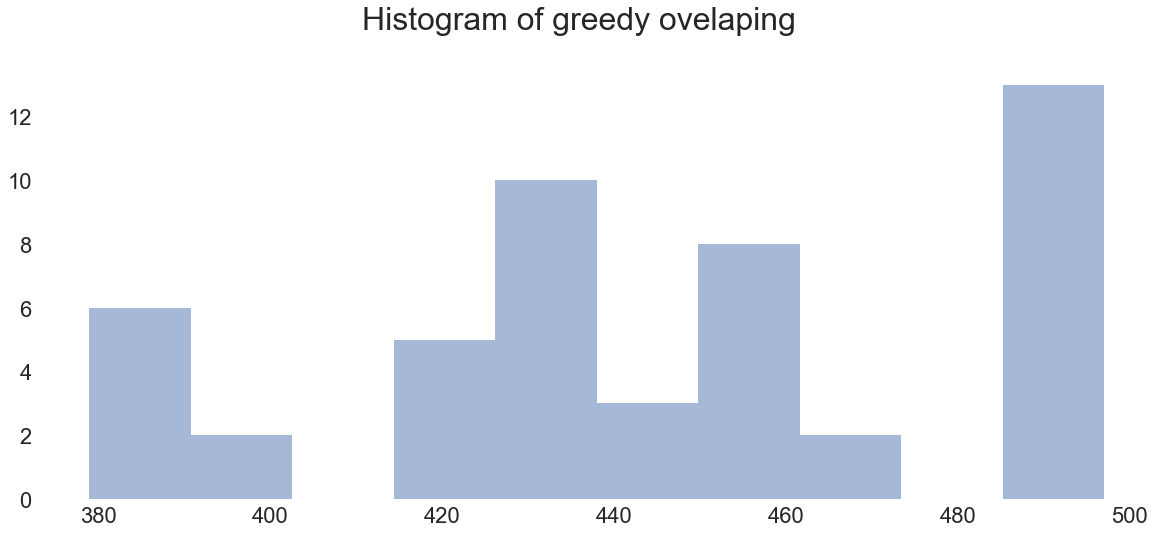

In [17]:
overlap = [np.trace(ct) for ct in cross_tabs]
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
plt.hist(overlap, bins=10, alpha=0.5)
plt.suptitle('Histogram of greedy ovelaping', fontsize=32)
ax.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=22)
fig.savefig('OverlapHist')
1-min(overlap)/505.

## Calculate clusters (BB needed)

In [18]:
if has_Bloomberg:
    print "Load yearly data from Bloomberg"
    centers = []
    rS_stat = {}
    for year in range(start,end):
        tickers, S, rS, classification, W, period, d, NM, rep, e, v , cl, centers, classification_and_clusters,\
        crossT, matched_classification = load_data_and_run_clustering(index, s_start.format(year), s_end.format(year),\
                                                                      centers, k, 0, path = "")
        rSstat[s_start.format(t) + "_" + s_end.format(t)] = rS

### Calculate and save descriptives

In [19]:
Desc = []
if has_Bloomberg:
    print "Calculate descriptives"
    for year in rS_stat.keys():
        temp_data = rS_stat[year]
        temp_data["betas"] = np.NaN
        desc = np.transpose(temp_data.describe())
        risk = calculate_beta_entropy(rSstat[year], rSPX)
        desc = desc.merge(risk, left_index=True, right_index=True)
        desc.to_csv("Desc_" + str.replace( year, "-", "") + ".csv")
        Desc.append(desc)
        print year
else:
    print "Load descriptives from csv"
    for year in range(start,end):
        Desc.append(read_data("Desc_" + str.replace(s_start.format(year) + "_" + s_end.format(year), "-", "") + ".csv"))
Desc[0].head(5)

Load descriptives from csv


,count,mean,std,min,25%,50%,75%,max,beta,entropy
USB UN Equity,251.0,0.001007,0.032453,-0.101124,-0.019103,-0.002635,0.018698,0.147799,1.073926,1.652048
1684442D UN Equity,251.0,0.000474,0.025441,-0.069620,-0.014663,0.000000,0.013700,0.108772,0.755430,1.749667
OAT UN Equity,251.0,0.001981,0.024173,-0.078756,-0.010400,0.000890,0.011832,0.120924,0.342960,1.527977
41018Q US Equity,251.0,-0.000087,0.026007,-0.187064,-0.015383,-0.001195,0.016609,0.137931,0.825899,1.119298
KBH UN Equity,251.0,0.001957,0.029810,-0.079407,-0.016561,0.000000,0.018123,0.130435,1.011779,1.688167


## Load raw BB classification data from disc

In [20]:
file_names_cluster_data = sorted(glob.glob(os.getcwd() + '\\Clusters_R_' + '[0-9]'*8 + '_' + '[0-9]'*8 +'.csv'))
cluster_data = {sf : read_data(sf) for sf in file_names_cluster_data}
cluster_data = reshuffle_cluster_labels(cluster_data, file_names_cluster_data[0])

### Compare GICS and BICS

In [ ]:
for k in cluster_data.keys():
    GBICS = cluster_data[k][['GICS_SECTOR_NAME' ,'BICS_LEVEL_1_SECTOR_NAME']].dropna().reset_index(drop=True)
    print(k, len(GBICS.index))
    pd.crosstab(GBICS[GBICS.columns[0]], GBICS[GBICS.columns[1]]).to_csv("BICS_GICS_{}.csv".\
                                                format("_".join(re.findall(r'[0-9]+', k)))) 

## Augmented CAPM

### Load SPX, CRSP data (BB needed)

In [22]:
if has_Bloomberg:
    print "Load SPX, CRSP data"
    SPX_CRSP = load_history(s_start.format(start), s_end.format(end), sids = ['CRSPTM1 Index', 'SPX Index'])
    rSPX_CRSP = (SPX_CRSP - SPX_CRSP .shift(1))/SPX_CRSP .shift(1)
    rSPX = pd.DataFrame(rSPX_CRSP['SPX Index'])

#### Calculate rolling correlation of SPX, CRSP

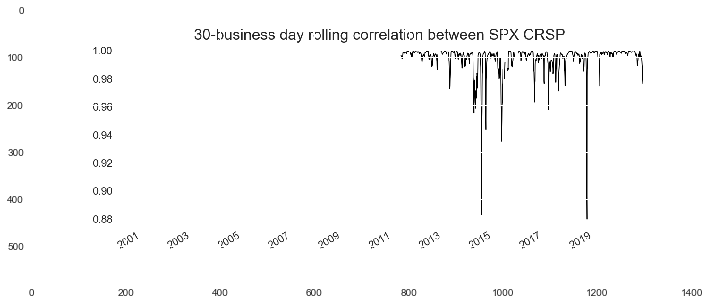

In [23]:
if has_Bloomberg:
    print "Plot rolling correlation of SPX, CRSP"
    fig, ax = plt.subplots(1, 1, figsize = (20, 8))
    SPX_CRSP['SPX Index'].rolling(30).corr(SPX_CRSP['CRSPTM1 Index']).\
        plot(grid = False, ax = ax, title= '30-business day rolling correlation between SPX CRSP', fontsize=22, color =['black'])
    ax.set_facecolor('white')
    ax.title.set_size(32)
    ax.legend(loc="best", prop={'size': 0})
    ax.xaxis.set_label_text('')
    fig.savefig('SPX_CRSP')
else:
    img=mpimg.imread('SPX_CRSP.png')
    plt.figure(figsize = (15,5))
    plt.imshow(img)

### Initialize CAPM

In [26]:
if has_Bloomberg:
    file_names_desc = glob.glob('Desc_' + '[0-9]'*8 + '_' + '[0-9]'*8 + '.csv')

    capm_reg = pd.DataFrame(columns=['const coeff', 'beta coeff', 'const p-vaule','beta p-value', 'Adj. R2'])
    coeff_table = pd.DataFrame()
    R2 = pd.DataFrame(columns=['year', 'Cluster', 'R2'])
    cluster_variables = ['Cluster', 'GICS_SECTOR_NAME', 'BICS_LEVEL_1_SECTOR_NAME']
    median_coeff_table = pd.DataFrame(columns=cluster_variables)
    n_sig_coeff_table = pd.DataFrame(columns=cluster_variables)

### Run CAPM/ Augmented CAPM OLS regressions

$$\mathrm{E^P}\left(\ln \frac{S_t}{S_{t-1}}\right) = r_t^f+ \beta \cdot \left(\mathrm{E^P}(r_t^M )-r_t^f\right)⋅cluster\_variable_{t-1} $$

In [27]:
if has_Bloomberg:
    for fn in file_names_cluster_data:
        # using the previous year clusters in the regression
        if fn == file_names_cluster_data[-1]:
            continue
        year = re.findall('\d{8}', fn)[0][:4]
        dscF = [sf for sf in file_names_desc if str(int(year)+1) in sf][0]
        desc = read_data(dscF)
        desc = desc.join(cluster_data[fn])
        X = desc['beta']
        X = sm.add_constant(X)
        y = desc['mean']
        # regression: mean ~ beta
        model = sm.OLS(y, X).fit()
        yyyy = re.findall('\d{4}',fn)[0]
        print yyyy
        capm_reg.loc[yyyy] = [model.params['const'], model.params['beta'], model.pvalues['const'],\
                             model.pvalues['beta'], model.rsquared_adj]
        medians = []
        n_sig = []
        for gr in cluster_variables:
            # regression: mean ~ beta * cluster
            mod = smf.ols(formula = "mean ~ beta:{}".format(gr), data = desc)
            res = mod.fit()
            s = res.summary()
            R2 = R2.append({"year" : yyyy, "Cluster" : gr, "R2" :res.rsquared_adj}, ignore_index=True)
            temp_coeff_table = s.tables[1].as_html()
            temp_coeff_table = pd.read_html(temp_coeff_table, header=0, index_col=0)[0]
            temp_coeff_table.index = [yyyy + " " + x for x in temp_coeff_table.index]
            if len(coeff_table.index) == 0:
                coeff_table = temp_coeff_table
            else:
                coeff_table = coeff_table.append(temp_coeff_table)
            medians.append(np.median(temp_coeff_table['P>|t|']))
            n_sig.append(sum(temp_coeff_table['P>|t|'] <0.05))
            # plot clusters
            groups = desc.groupby(gr)
            # # Plot
            plt.figure(figsize=(16, 8))
            fig = plt.figure(1)
            ax = plt.subplot(1, 1, 1, facecolor='white') # nrows, ncols, index
            ax.tick_params(labelsize = 22)
            ax.margins(0.05)
            colors = cm.gist_rainbow(np.linspace(0, 1, len(desc[gr].unique())))
            for g, c in zip(groups, colors):
                ax.scatter(g[1]['beta'], g[1]['mean'], color = c, label=g[0])
                ax.legend()
            fig.savefig(yyyy + gr)
            fig.clear()
        # add median, number of significant coefficients         
        median_coeff_table.loc[yyyy] = medians
        n_sig_coeff_table.loc[yyyy] = n_sig
    # prepare and save R2

### Save CAPM OLS regressions

In [31]:
if has_Bloomberg:
    # make sure after initialization, regression was run only once
    r2 = R2.set_index(['year','Cluster']).unstack().reset_index()
    r2.set_index('year', inplace=True)
    r2.columns = r2.columns.droplevel(0)
    r2 = r2.join(capm_reg['Adj. R2'], how = 'outer')
    r2.rename(columns={R2.columns[-1]: 'CAPM'}, inplace = True)
    r2.to_csv("CAPM_R2.csv")
    # save coefficients
    capm_reg.to_csv('CAPM_reg.csv')
    coeff_table.to_csv('CAPM_Cluster.csv')

### Read augmented CAPM regression data from files

In [32]:
coeffs = read_data(os.getcwd() + '\\CAPM_Cluster.csv')
coeffs['year'] = [x.split(" ")[0] for x in coeffs.index]
coeffs['cluster'] = [x.split(":")[1].split("[")[0] if len(x.split(":")) > 1 else np.NaN for x in coeffs.index]
# Intercepts
coeffs = coeffs.fillna(method = 'bfill')
# Medians
median_coeff_table = coeffs[['P>|t|', 'year', 'cluster']].groupby(['year','cluster']).median()
# Number of significant coefficients
coeffs['P>|t|'] = coeffs['P>|t|'] < 0.05
n_sig_coeff_table = coeffs[['P>|t|', 'year', 'cluster']].groupby(['year','cluster']).sum()

def unstack(coeffs):
    coeffs = coeffs.unstack()
    coeffs.index = list(coeffs.index)
    coeffs.columns = coeffs.columns.droplevel(0)
    return coeffs
    
median_coeff_table = unstack(median_coeff_table)
n_sig_coeff_table = unstack(n_sig_coeff_table)

### Plot augmented CAPM OLS R2

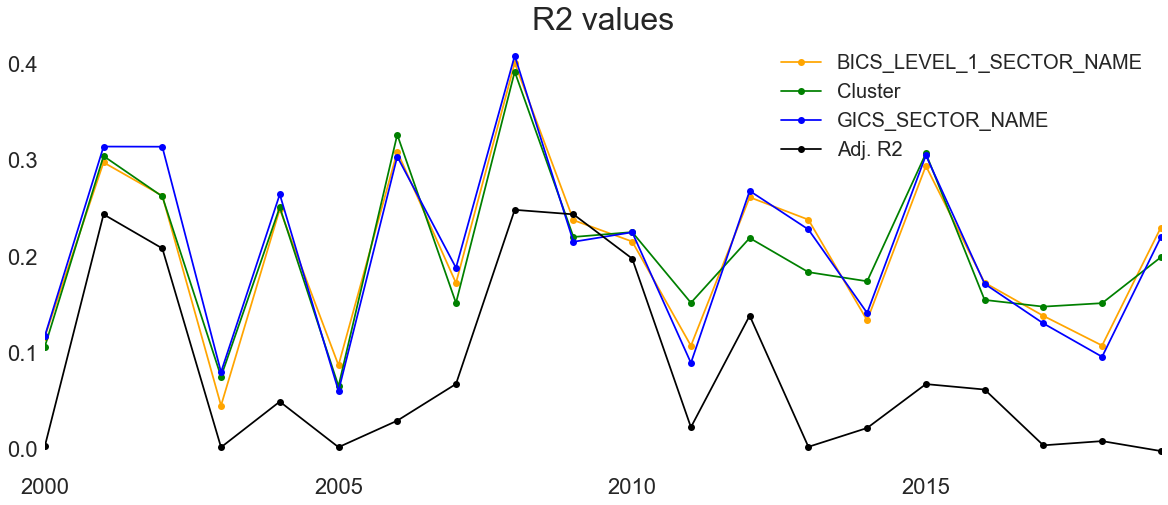

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
r2.plot(style = '-o', grid = False, ax = ax, title= 'R2 values', fontsize=22, color =['orange', 'green', 'blue', 'black'])
ax.set_facecolor('white')
ax.title.set_size(32)
ax.legend(loc="best", prop={'size': 20})
ax.xaxis.set_label_text('')
fig.savefig('CAPM_R2')

### Plot augmented CAPM OLS p-values

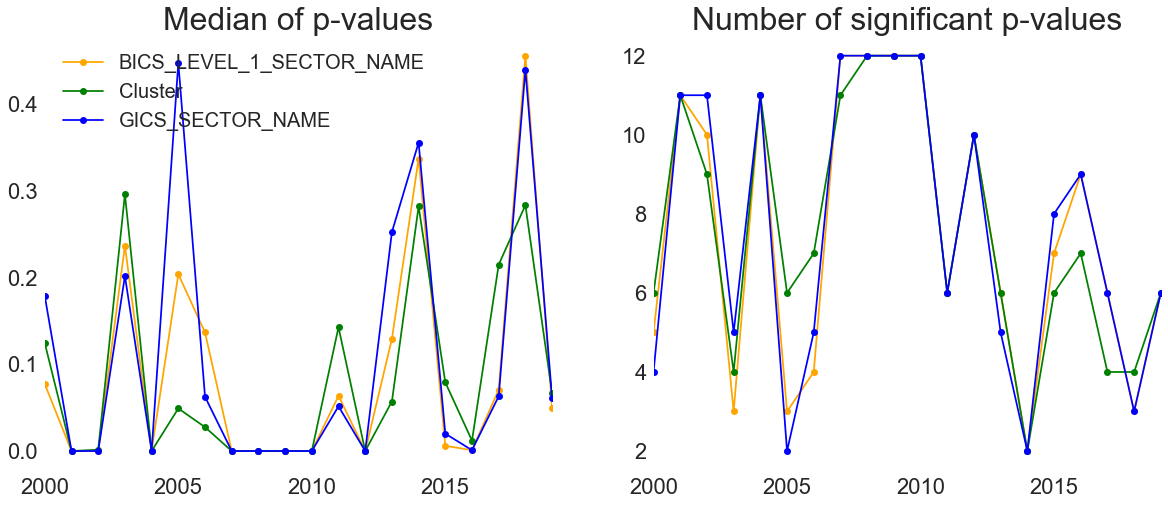

In [34]:
fig, axs = plt.subplots(1,2 , figsize = (20, 8))
median_coeff_table.plot(style = '-o', grid = False, ax = axs[0],\
                        title= 'Median of p-values', fontsize=22, color =['orange', 'green', 'blue'])
n_sig_coeff_table.plot(style = '-o', grid = False, ax = axs[1],\
                       title= 'Number of significant p-values', fontsize=22, color =['orange', 'green', 'blue'])
[ax.set_facecolor('white') for ax in axs]
[ax.title.set_size(32) for ax in axs]
axs[0].legend(loc="best", prop={'size': 20})
axs[1].legend().set_visible(False)
fig.savefig('CAPM_median_n_sig')